<a href="https://colab.research.google.com/github/caroccialberto/ML2025/blob/main/Carocci_ML2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alberto Carocci, Corso ML 2025
Il data set in oggetto ha come variabile di interesse la positività o meno al virus dell'epatite E (HEV). Il focus dello studio è quello di capire quali variabili siano maggiormente correlate con tale infezzione, sia in come fonte di rischio, sia come fattore di rischio.

In [ ]:
from google.colab import files
import numpy as np
import pandas as pd

# Modeling
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Explainability
import shap

# Visualization
import matplotlib.pyplot as plt

# Initialize JS for SHAP visualisations inside Jupyter
shap.initjs()

In [ ]:
# Esegui questa cella per caricare il tuo file XLSX
uploaded = files.upload()

# Stampa i nomi dei file caricati per verifica
for fn in uploaded.keys():
  print(f'User uploaded file "{fn}"')


Saving dati.xlsx to dati.xlsx
User uploaded file "dati.xlsx"


In [ ]:
df = pd.read_excel("dati.xlsx")
display(df.head())

,contatti_animali,cane,gatto,maiali,pecore,bovini,polli,cavalli,cinghiali,giardinaggio,...,salsicce_fegato,vegetali_del_proprio_orto,frutti_di_mare,viaggi,HEV,cont_animal_dom,cont_animal_wild,ort_giardino,genere,etaz
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.293247
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.116964
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,0.0,-0.881972
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,0.0,-1.352060
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,0.0,-0.764450


### Preparazione del Dataset per SHAP

Ora divideremo il dataset `df` in variabili predittive (`X`) e variabile target (`y`).

*   `X` conterrà tutte le colonne eccetto `HEV`.
*   `y` conterrà solo la colonna `HEV`.

In [ ]:
# Assicurati che 'HEV' sia una colonna nel tuo DataFrame
if 'HEV' in df.columns:
    y = df['HEV']
    X = df.drop('HEV', axis=1)
    print("Dataset separato in X (features) e y (target).")
    print("Prime 5 righe di X:")
    display(X.head())
    print("Prime 5 righe di y:")
    display(y.head())
else:
    print("Errore: La colonna 'HEV' non è presente nel DataFrame. Verifica il nome della colonna.")


Dataset separato in X (features) e y (target).
Prime 5 righe di X:


,contatti_animali,cane,gatto,maiali,pecore,bovini,polli,cavalli,cinghiali,giardinaggio,...,salsicce_cinghiale,salsicce_fegato,vegetali_del_proprio_orto,frutti_di_mare,viaggi,cont_animal_dom,cont_animal_wild,ort_giardino,genere,etaz
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.293247
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.116964
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,-0.881972
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,0.0,-1.352060
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,0.0,-0.764450


Prime 5 righe di y:


,HEV
0,1.0
1,0.0
2,0.0
3,0.0
4,1.0


Ho tenuto i grafici che seguono anche se in questo caso essendo tutte variabili 0 - 1 hanno pochissimo senso

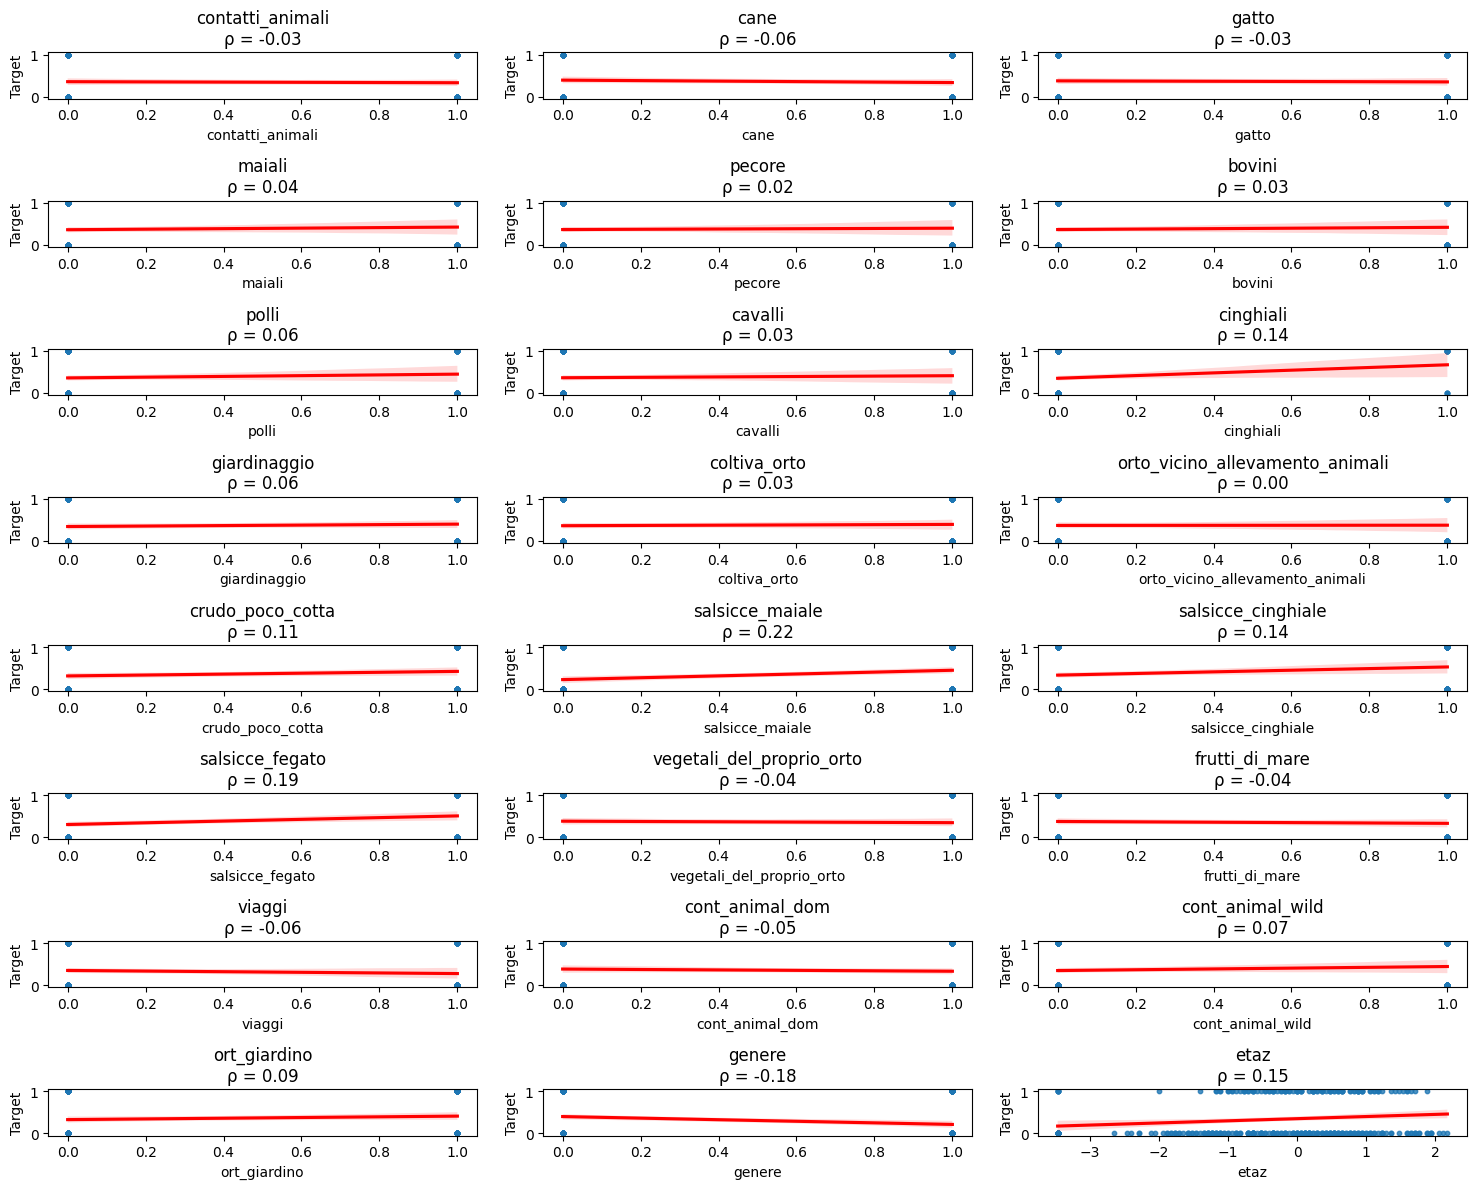

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
import math
import pandas as pd

def plot_feature_correlations(X, y, figsize=(15, 12)):
    """
    Plots each feature in X against the target y with a linear fit and Pearson correlation.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (array-like): Target values.
        figsize (tuple): Size of the overall figure grid.
    """
    # Convert all columns in X to numeric types, coercing errors to NaN
    X_numeric = X.apply(pd.to_numeric, errors='coerce')

    # Filter out columns that are entirely NaN after coercion (i.e., non-numeric)
    # or columns that have only one unique value (constant), as pearsonr would fail
    numeric_columns = [col for col in X_numeric.columns if X_numeric[col].nunique() > 1 and not X_numeric[col].isnull().all()]

    if not numeric_columns:
        print("No suitable numeric features found to plot correlations.")
        return

    n_features = len(numeric_columns)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)

    plt.figure(figsize=figsize)

    for i, column in enumerate(numeric_columns):
        plt.subplot(n_rows, n_cols, i + 1)

        # Create a temporary DataFrame for the current feature and target, dropping NaNs
        # to ensure alignment and valid data for pearsonr and regplot
        temp_data = pd.DataFrame({'feature': X_numeric[column], 'target': y}).dropna()

        if not temp_data.empty and temp_data['feature'].nunique() > 1: # Re-check after dropping NaNs
            sns.regplot(x=temp_data['feature'], y=temp_data['target'], scatter_kws={'s': 10}, line_kws={'color': 'red'})
            corr, _ = spearmanr(temp_data['feature'], temp_data['target'])
            plt.title(f"{column}\nρ = {corr:.2f}")
            plt.xlabel(column)
            plt.ylabel("Target")
        else:
            # If after cleaning, the column is empty or constant, plot an empty subplot with a message
            plt.text(0.5, 0.5, f"'{column}' is constant or has no valid data.",
                     horizontalalignment='center', verticalalignment='center',
                     transform=plt.gca().transAxes)
            plt.title(f"{column}")
            plt.xlabel(column)
            plt.ylabel("Target")


    plt.tight_layout()
    plt.show()
plot_feature_correlations(X, y)

Divisiono in train, test e validation Set

In [ ]:
# Split the data into training and test sets

# Before splitting, handle NaN values in y if any exist
# Create a mask for non-NaN values in y
non_nan_mask = y.notna()

# Apply the mask to both X and y
X_cleaned = X[non_nan_mask]
y_cleaned = y[non_nan_mask]

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_cleaned, y_cleaned, test_size=0.4, random_state=42, stratify=y_cleaned
)

# Second split: 20% validation, 20% test from the temp set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training size: {X_train.shape}")
print(f"Validation size: {X_val.shape}, Test size: {X_test.shape}")

Training size: (203, 24)
Validation size: (68, 24), Test size: (68, 24)


Uso XGBClassifier, modifico quindi la funzione obbiettivo e la loss function, per adattarla ad un cassfiicatore

In [ ]:

params = {
    "tree_method": "hist",            # Use histogram-based tree construction (fast and scalable)
    "booster": "gbtree",              # Use gradient boosted trees (not DART or linear booster)
    "learning_rate": 0.01,            # Shrinks the contribution of each tree (also called eta)
    "objective": "binary:logistic",  # Regression task using squared error as loss function
    "base_score": np.mean(y_train),   # Initial prediction score (use target mean for regression)
    "gamma": 0.3,                     # Minimum loss reduction to make a further split (prunes tree)
    "max_depth": 4,                   # Maximum depth of each tree (controls model complexity)
    "min_child_weight": 4,           # Minimum sum of weights (samples) to create a new child node
    "reg_lambda": 0.1,               # L2 regularization term on weights (Ridge-like)
    "reg_alpha": 0.1,                # L1 regularization term on weights (Lasso-like)
    "n_estimators": 4000,            # Maximum number of boosting rounds (trees)
    "eval_metric": "logloss",           # Evaluation metric: logloss
    "colsample_bytree": 0.4,         # Fraction of features to sample for each tree
    "colsample_bylevel": 0.6,        # Fraction of features for each level in a tree
    "colsample_bynode": 0.6,         # Fraction of features for each node split
    "subsample": 0.5,                # Fraction of training data to use per boosting round (row sampling)
    "grow_policy": "lossguide",      # Prioritize splits that reduce loss most (not just depth)
    "validate_parameters": True,     # Ensure parameter values are valid before training
    "n_jobs": 4,                     # Number of threads for parallel computation

}

model = xgb.XGBClassifier(**params)



model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBClassifier(base_score=np.float64(0.3399014778325123), booster='gbtree',
              callbacks=None, colsample_bylevel=0.6, colsample_bynode=0.6,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.3,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4000, n_jobs=4,
              num_parallel_tree=None, ...)

La varibile che compare di più è quella dell'età, quella che non dovrebbe avere NaN (o ne ha pochissimi)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

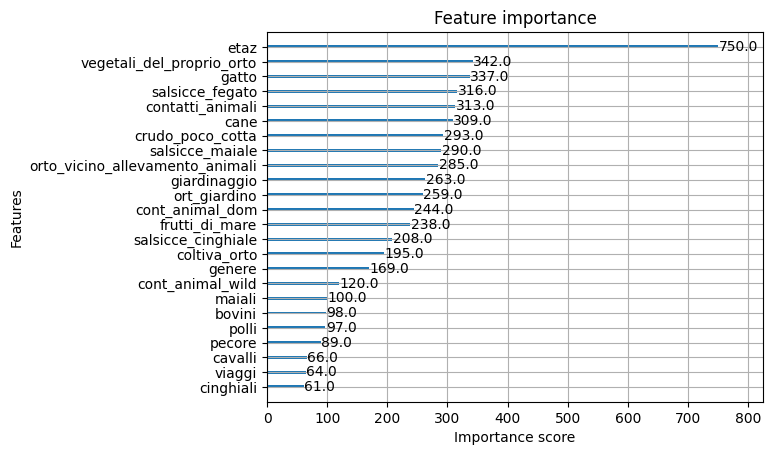

In [ ]:
import graphviz
xgb.plot_importance(model)

/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


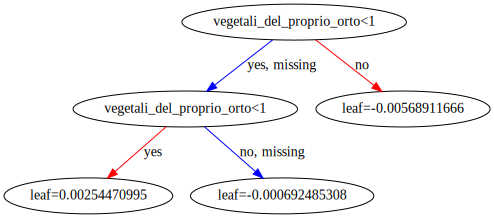

In [ ]:
# converts the target tree to a graphviz instance
#xgboost.to_graphviz(model, num_trees=model.best_iteration)
xgb.to_graphviz(model, num_trees=1)

In questo caso per valutare il modello ricorro ad una rappresentazione grafica ti tipo ROC Curve, Riportatndo il valore dell'AUC. Il modello sembra overfittare, predice bene i dati del train, ma non riesce a predirre ne test ne validation, quindi il modello non è buono.

AUC Train:       0.847
AUC Validation:  0.514
AUC Test:        0.587


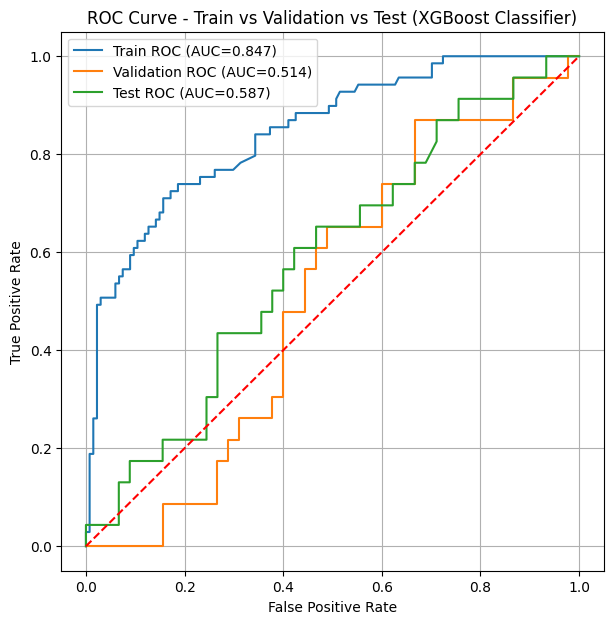

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# === TRAIN ===
pred_proba_train = model.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, pred_proba_train)
fpr_train, tpr_train, _ = roc_curve(y_train, pred_proba_train)

# === VALIDATION ===
pred_proba_val = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, pred_proba_val)
fpr_val, tpr_val, _ = roc_curve(y_val, pred_proba_val)

# === TEST ===
pred_proba_test = model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, pred_proba_test)
fpr_test, tpr_test, _ = roc_curve(y_test, pred_proba_test)

print(f"AUC Train:       {auc_train:.3f}")
print(f"AUC Validation:  {auc_val:.3f}")
print(f"AUC Test:        {auc_test:.3f}")

# === Plot ===
plt.figure(figsize=(7,7))

plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC={auc_train:.3f})")
plt.plot(fpr_val,   tpr_val,   label=f"Validation ROC (AUC={auc_val:.3f})")
plt.plot(fpr_test,  tpr_test,  label=f"Test ROC (AUC={auc_test:.3f})")

plt.plot([0,1], [0,1], 'r--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Train vs Validation vs Test (XGBoost Classifier)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

print("Shape of SHAP values:", shap_values.shape)


Shape of SHAP values: (68, 24)


Real value: 1.00
Predicted value: 0.35
Residual: 0.65


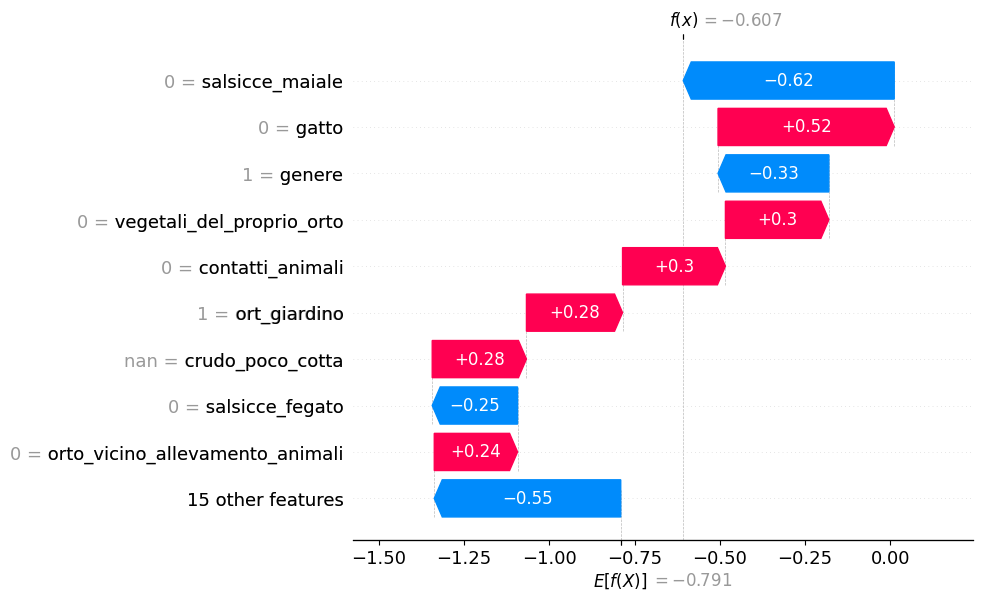

In [ ]:
#print real value and prediction for one element and residual
idx=1
print(f"Real value: {y_test.iloc[idx]:1.2f}")# ground truth
print(f"Predicted value: {pred_proba_test[idx]:1.2f}") # output of the regressor
print(f"Residual: {y_test.iloc[idx]-pred_proba_test[idx]:1.2f}")
# Display one prediction explanation
shap.plots.waterfall(shap_values[idx])

Nei grafici successivi cerco di capire come le variabili influenzino l'output del modello.Spesso la divisione è netta, come nelle variabbili  Gatto, Salsicce di maiale, ecc. Nelle punteggio di previsione sembra che la variabile contati con i gatti sia una di quelle che faccia aumentare il rischio di contrazione del HEV.

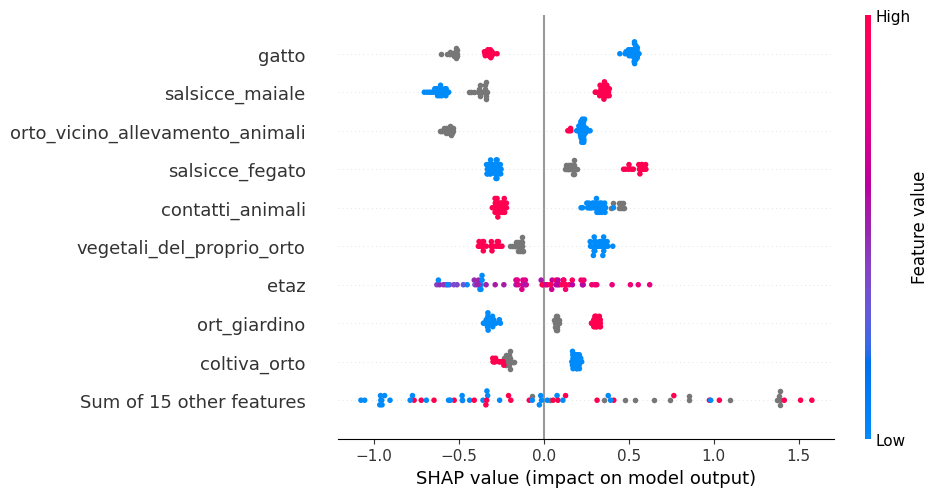

In [ ]:
# Summary plot (beeswarm) for global feature importance
shap.plots.beeswarm(shap_values)

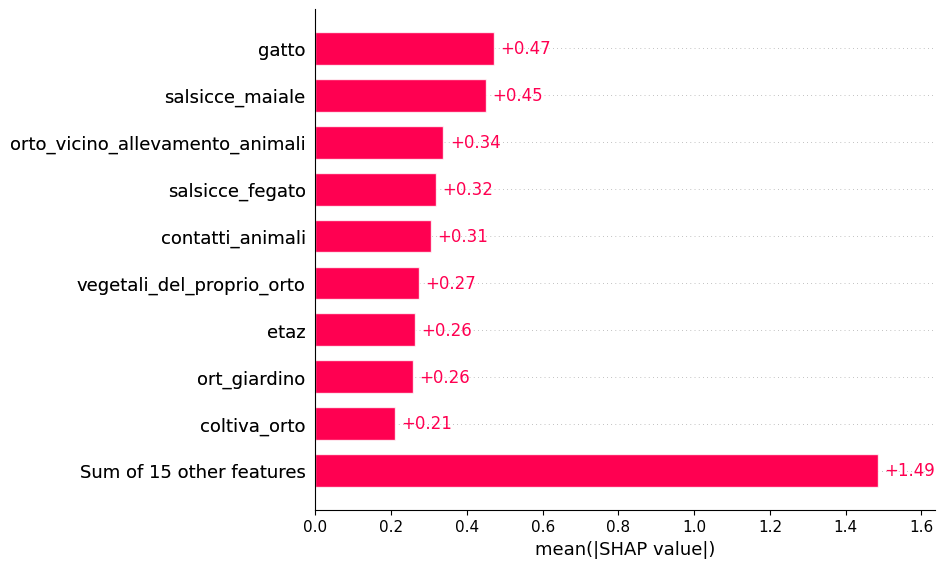

In [ ]:
# Bar plot of mean(|SHAP value|) for each feature
shap.plots.bar(shap_values)

['contatti_animali', 'cane', 'gatto', 'maiali', 'pecore', 'bovini', 'polli', 'cavalli', 'cinghiali', 'giardinaggio', 'coltiva_orto', 'orto_vicino_allevamento_animali', 'crudo_poco_cotta', 'salsicce_maiale', 'salsicce_cinghiale', 'salsicce_fegato', 'vegetali_del_proprio_orto', 'frutti_di_mare', 'viaggi', 'cont_animal_dom', 'cont_animal_wild', 'ort_giardino', 'genere', 'etaz']


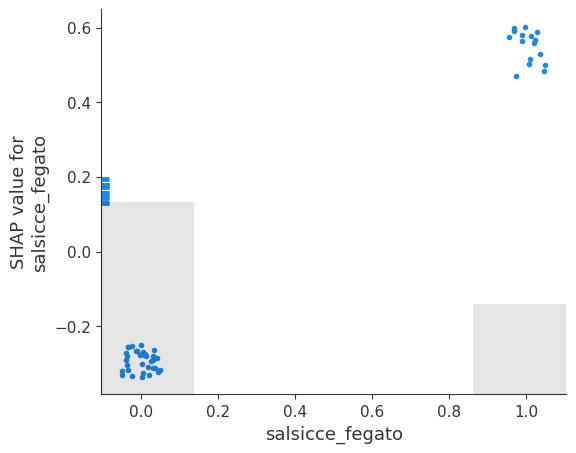

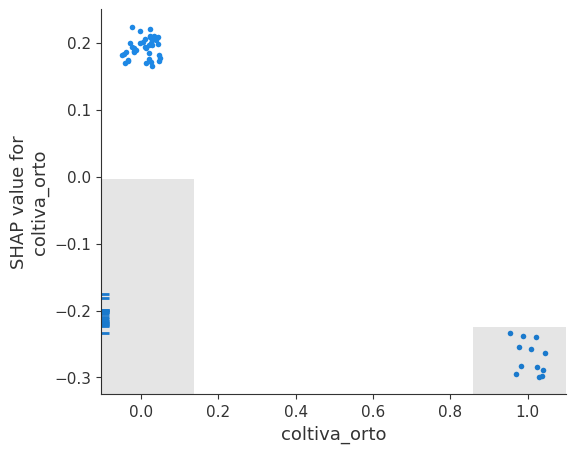

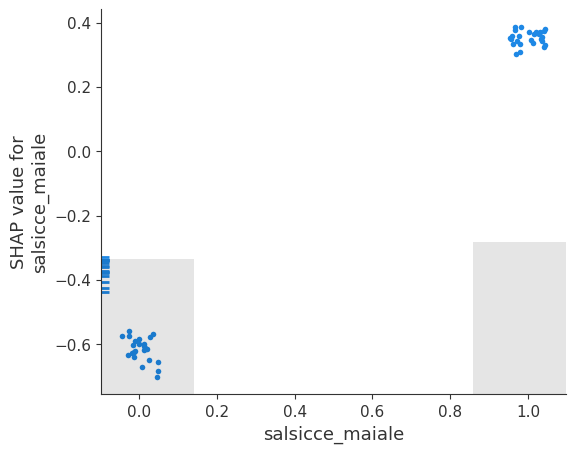

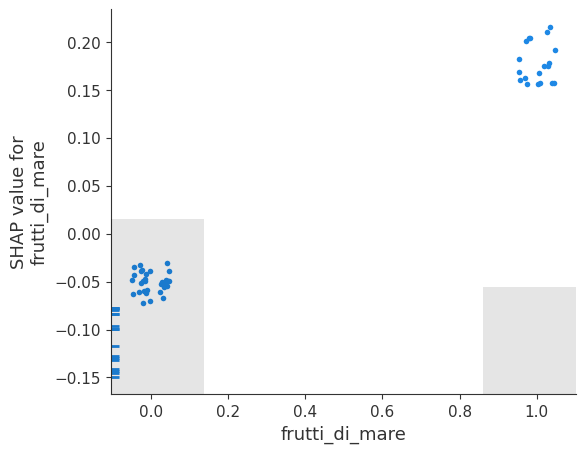

In [ ]:
# Dependence plot for a single feature (e.g., 'bmi')
#shap.plots.scatter(shap_values, feature="bmi")
print(shap_values.feature_names)
shap.plots.scatter(shap_values[:, "salsicce_fegato"])
shap.plots.scatter(shap_values[:, "coltiva_orto"])
shap.plots.scatter(shap_values[:, 'salsicce_maiale'])
shap.plots.scatter(shap_values[:, 'frutti_di_mare'])